In [1]:
import os, re
from datetime import datetime

import pandas as pd
import numpy as np
import seaborn as sns

from utils.process import categorize, scale, tokenize, stem, unidecode
#, stop_words
from utils.metrics import mean_absolute_percentage_error

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score

## TODO

- Test multiple algorithm (Create a model object)
- CountVectorizer
- Aggregate data from AutoPlus

## Import dataset

In [2]:
# See working directory (No need, just for myself)
os.getcwd()

'/Users/stevenr/Documents/Cours_MD5/projet_data/23 mai/data_project-bnpoirier-work'

In [3]:
df = pd.read_csv('./data_cars.csv')

In [4]:
df.head(10)

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description
0,11220.0,PEUGEOT,308,2014,94341.0 km,Diesel,mécanique,06/07/2018 à 3h47,"modele: 308 (2E GENERATION), version: 1.6 HDI ..."
1,57526.0,BMW,X6,2015,39051.0 km,Diesel,automatique,03/04/2018 à 16h41,"modele: X6 F16, version: (F16) XDRIVE30D 258 M..."
2,80379.0,AUDI,RS6,2014,75381.0 km,Essence,automatique,30/07/2018 à 1h55,"modele: RS6 (3E GENERATION) AVANT, version: II..."
3,2830.0,FORD,KA,2007,92282.0 km,Essence,mécanique,09/07/2018 à 14h12,"modele: KA, version: 1.3 70 FUN, puissance_fis..."
4,12925.0,FIAT,TIPO,2018,10.0 km,Essence,mécanique,19/05/2018 à 3h52,"modele: TIPO 2 SW, version: II SW 1.4 95 POP, ..."
5,27956.0,BMW,X3,2012,95623.0 km,Diesel,automatique,14/03/2018 à 4h24,"modele: X3 F25, version: (F25) XDRIVE35D 313 S..."
6,16888.0,AUDI,A3,2013,49018.0 km,Diesel,mécanique,16/04/2018 à 21h35,"modele: A3 (2E GENERATION) SPORTBACK, version:..."
7,18188.0,RENAULT,MEGANE,2017,9795.0 km,Diesel,automatique,29/04/2018 à 12h44,"modele: MEGANE 4 ESTATE, version: IV ESTATE 1...."
8,10594.0,FORD,C-MAX,2012,126670.0 km,Diesel,mécanique,22/06/2018 à 5h11,"modele: C-MAX 2, version: II 1.6 TDCI 115 FAP ..."
9,69131.0,MERCEDES,CLASSE C,2015,39439.0 km,Essence,automatique,08/03/2018 à 17h35,"modele: CLASSE C 4 AMG, version: (W205) 63 AMG..."


## Observations

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline

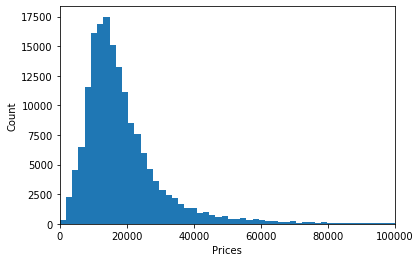

In [6]:
# Price repartition
plt.hist(df["Price"], 800)
plt.xlim(0, 100000)
plt.xlabel('Prices')
plt.ylabel('Count')
plt.show()

Les prix semblent s'agglutiner entre 20000 et 25000 €

Text(0, 0.5, 'Number of cars')

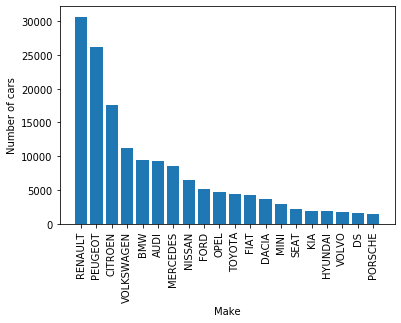

In [7]:
# Make cars counts
counts = df["Make"].value_counts().iloc[0:20]
names = counts.keys().to_numpy()
values = counts.to_numpy()

plt.bar(names, values)
plt.xticks(rotation="vertical")
plt.xlabel("Make")
plt.ylabel("Number of cars")

Le dataset contient beaucoup de voitures Renault, Peugeot et Citroen que de voitures de marque étrangère (BMW, Ford, Mercedes)

## Some data cleaning

### Data types conversions

In [8]:
## Remove kilometers and convert to number
df["Mileage"] = df["Mileage"].str.replace(' km', '').astype("float64")
df.head(5)

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description
0,11220.0,PEUGEOT,308,2014,94341.0,Diesel,mécanique,06/07/2018 à 3h47,"modele: 308 (2E GENERATION), version: 1.6 HDI ..."
1,57526.0,BMW,X6,2015,39051.0,Diesel,automatique,03/04/2018 à 16h41,"modele: X6 F16, version: (F16) XDRIVE30D 258 M..."
2,80379.0,AUDI,RS6,2014,75381.0,Essence,automatique,30/07/2018 à 1h55,"modele: RS6 (3E GENERATION) AVANT, version: II..."
3,2830.0,FORD,KA,2007,92282.0,Essence,mécanique,09/07/2018 à 14h12,"modele: KA, version: 1.3 70 FUN, puissance_fis..."
4,12925.0,FIAT,TIPO,2018,10.0,Essence,mécanique,19/05/2018 à 3h52,"modele: TIPO 2 SW, version: II SW 1.4 95 POP, ..."


In [9]:
df.dtypes['Mileage']

dtype('float64')

In [10]:
df["Mileage"].isna().sum()

0

In [11]:
# Reduce allocated bytes size for "Model_year" 
df["Model_year"] = df["Model_year"].astype("int16")

## Feature engineering

In [12]:
# Compute age
# df['Posted_on_ts'] = df['Online'].map(lambda date: datetime.strptime(date, '%d/%m/%Y à %Hh%M').timestamp())
# df['Model_year_ts'] = df['Model_year'].map(lambda year: datetime.strptime(str(year), '%Y').timestamp())
# df['Model_age_ts'] = df['Posted_on_ts'] - df['Model_year_ts']
# df.drop(columns=['Posted_on_ts', 'Model_year_ts'])

In [13]:
# We choose 2018 because it was the year the sellers published their offers
df['Model_age'] = df.apply(lambda row: 2018 - row.Model_year, axis = 1)

In [14]:
# See an example of a desc
df['Description'][1]

"modele: X6 F16, version: (F16) XDRIVE30D 258 M SPORT BVA8, puissance_fiscale: 16, portes: 5.0, options: triangle de presignalisation et trousse de premiers secours;volant cuir;pack alu;affichage tête haute;GPS;appel d'urgence intelligent;prise 12v additionnelle;sieges advanced pour conducteur et passager avant;projecteurs antibrouillard;climatisation automatique multi zone;pack suspension adaptative;&quotcarbonschwarz&quot metallise;caméra de recul;finition m sport;jantes alu 20&quot;pack innovation;kit fumeurs;rétroviseurs rabattables électriquement;shadow line brillant;information trafic en temps reel rtti (3ans);aide parking;contrôle de pression des pneus;système audio Harman Kardon;surround view;sièges électrique à mémoire;conciergerie (3 ans);fonctions &quotma bmw a distance&quot;pack safety;airbag passager desactivable via la cle;services connecteddrive (bmw online 3 ans + bmw apps);pack M;planche de bord en cuir;info trafic tmc;lave-phares;ciel de pavillon anthracite;services b

In [15]:
# Getting the number of doors on the car
df['Doors'] = df['Description'].str.extract("portes: ([0-9]+)").astype("float32")

In [16]:
# Getting the horse power of a car
df['Fisc_hp'] = df['Description'].str.extract("puissance_fiscale: ([0-9]+)").astype("float32")

In [17]:
# Getting the car's version
df['version'] = df['Description'].apply(lambda x : x.split('version: ')[-1].split(', puissance_fiscale')[0])

In [18]:
df.head()

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description,Model_age,Doors,Fisc_hp,version
0,11220.0,PEUGEOT,308,2014,94341.0,Diesel,mécanique,06/07/2018 à 3h47,"modele: 308 (2E GENERATION), version: 1.6 HDI ...",4,5.0,4.0,1.6 HDI FAP 92CH BUSINESS 5P
1,57526.0,BMW,X6,2015,39051.0,Diesel,automatique,03/04/2018 à 16h41,"modele: X6 F16, version: (F16) XDRIVE30D 258 M...",3,5.0,16.0,(F16) XDRIVE30D 258 M SPORT BVA8
2,80379.0,AUDI,RS6,2014,75381.0,Essence,automatique,30/07/2018 à 1h55,"modele: RS6 (3E GENERATION) AVANT, version: II...",4,5.0,47.0,III AVANT 4.0 TFSI 560 QUATTRO TIPTRONIC
3,2830.0,FORD,KA,2007,92282.0,Essence,mécanique,09/07/2018 à 14h12,"modele: KA, version: 1.3 70 FUN, puissance_fis...",11,3.0,5.0,1.3 70 FUN
4,12925.0,FIAT,TIPO,2018,10.0,Essence,mécanique,19/05/2018 à 3h52,"modele: TIPO 2 SW, version: II SW 1.4 95 POP, ...",0,5.0,5.0,II SW 1.4 95 POP


### Language processing

## Data checks (null or NaN)

In [19]:
# Check for null values
df.isnull().sum()


Price             0
Make              0
Model             0
Model_year        0
Mileage           0
Fuel              0
Gearbox           0
Online            0
Description       0
Model_age         0
Doors          1289
Fisc_hp           0
version           0
dtype: int64

In [20]:
# Check for invalid numbers
df.isna().sum()

Price             0
Make              0
Model             0
Model_year        0
Mileage           0
Fuel              0
Gearbox           0
Online            0
Description       0
Model_age         0
Doors          1289
Fisc_hp           0
version           0
dtype: int64

In [21]:
# Find empty strings
np.where(df.applymap(lambda x: x == ''))

(array([], dtype=int64), array([], dtype=int64))

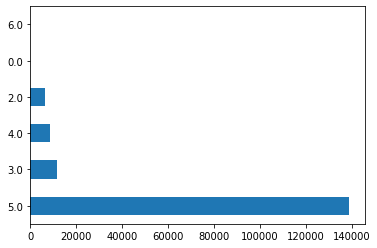

In [22]:
# Handling NA for Doors
df['Doors'].value_counts().plot(kind='barh')

In [23]:
bins = [-np.inf, 4, np.inf]
labels=['4','5']
df['Doors'] = pd.cut(df['Doors'], bins=bins, labels=labels)

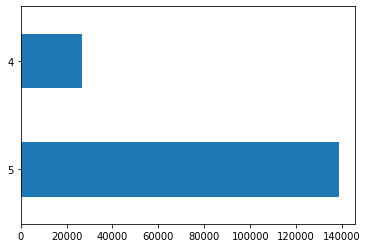

In [24]:
df['Doors'].value_counts().plot(kind='barh')

In [25]:
df.dropna(subset=['Doors'], inplace=True)

In [26]:
indexNames = df[(df['Doors'] == ',')].index
df.drop(indexNames , inplace=True)

In [27]:
df['Doors'] = df['Doors'].astype(str).astype("float64")

## Checking for outliers

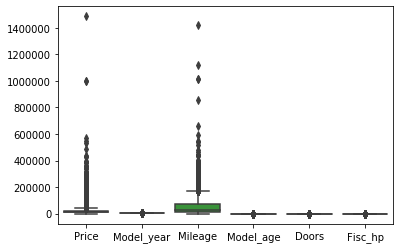

In [28]:
sns.boxplot(data=df)

#### Check of Model_year, Fisc_hp, Doors outliers

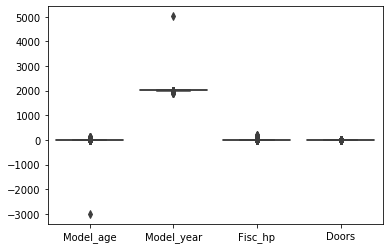

In [29]:
sns.boxplot(data=df[['Model_age','Model_year','Fisc_hp','Doors']])

In [30]:
df = df.drop(df[df.Model_year > 3000].index)

In [31]:
df = df.drop(df[df.Fisc_hp > 1000].index)

In [32]:
df = df.drop(df[df.Fisc_hp <= 0].index)

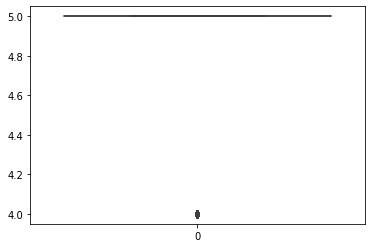

In [33]:
sns.boxplot(data=df['Doors'])

In [34]:
#df = df.drop(df[df.Doors <= 0].index)

#### Checking for Price outliers

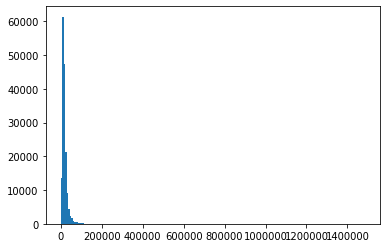

In [35]:
plt.hist(df['Price'], bins=200, range=(df['Price'].min(), df['Price'].max()))
plt.show()

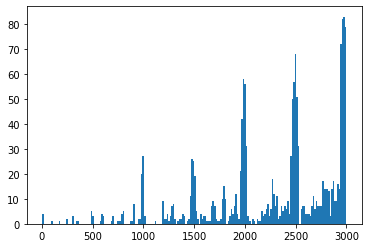

In [36]:
plt.hist(df['Price'], bins=200, range=(df['Price'].min(), 3000))
plt.show()

In [37]:
# Cheap cars sold lower than 150 euros are rare
df = df.drop(df[df.Price <= 400].index)

In [38]:
df["Model_year"] = df["Model_year"].astype("int16")

In [39]:
# 
bins = [-np.inf, 27438,54876,82314,109752, 137190, np.inf]
labels=['<27437','27438-54876','54876-82314', '82314-109752', '109752-137190','>137190']
df['Mileage_par_tranche'] = pd.cut(df['Mileage'], bins=bins, labels=labels)

In [40]:
bins = [-np.inf, 2,4,6,8, np.inf]
labels=['1','2-4','4-6','6-8','>10']
df['age_voiture'] = pd.cut(df['Model_age'], bins=bins, labels=labels)

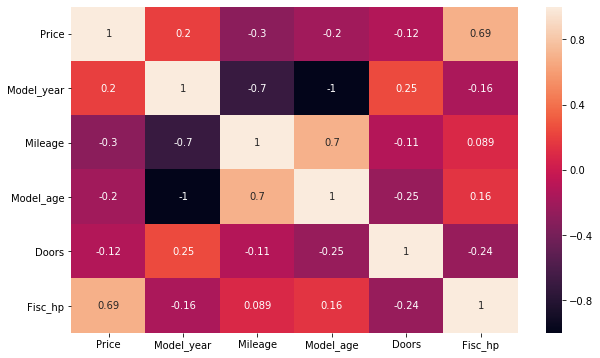

In [41]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True)

## Data normalization

In [42]:
df[['Model_age', 'Mileage']] = scale(df[['Model_age', 'Mileage']])

## Hot encoding

In [43]:
# List categorical columns
df["Fuel"].unique()

array(['Diesel', 'Essence', 'Hybride essence électrique', 'Electrique',
       'Hybride diesel électrique', 'Bicarburation essence GPL',
       'Bicarburation essence bioéthanol'], dtype=object)

In [44]:
# List categorical columns for Gearbox
df["Gearbox"].unique()

array(['mécanique', 'automatique'], dtype=object)

In [45]:
df = pd.get_dummies(df, columns=["Gearbox"], drop_first=True)

In [46]:
# List categorical columns
df = pd.get_dummies(df, columns=["Fuel"])

In [47]:
df.head(5)

,Price,Make,Model,Model_year,Mileage,Online,Description,Model_age,Doors,Fisc_hp,...,Mileage_par_tranche,age_voiture,Gearbox_mécanique,Fuel_Bicarburation essence GPL,Fuel_Bicarburation essence bioéthanol,Fuel_Diesel,Fuel_Electrique,Fuel_Essence,Fuel_Hybride diesel électrique,Fuel_Hybride essence électrique
0,11220.0,PEUGEOT,308,2014,0.988870,06/07/2018 à 3h47,"modele: 308 (2E GENERATION), version: 1.6 HDI ...",0.159578,5.0,4.0,...,82314-109752,2-4,1,0,0,1,0,0,0,0
1,57526.0,BMW,X6,2015,-0.162624,03/04/2018 à 16h41,"modele: X6 F16, version: (F16) XDRIVE30D 258 M...",-0.106209,5.0,16.0,...,27438-54876,2-4,0,0,0,1,0,0,0,0
2,80379.0,AUDI,RS6,2014,0.594001,30/07/2018 à 1h55,"modele: RS6 (3E GENERATION) AVANT, version: II...",0.159578,5.0,47.0,...,54876-82314,2-4,0,0,0,0,0,1,0,0
3,2830.0,FORD,KA,2007,0.945989,09/07/2018 à 14h12,"modele: KA, version: 1.3 70 FUN, puissance_fis...",2.020083,4.0,5.0,...,82314-109752,>10,1,0,0,0,0,1,0,0
4,12925.0,FIAT,TIPO,2018,-0.975709,19/05/2018 à 3h52,"modele: TIPO 2 SW, version: II SW 1.4 95 POP, ...",-0.903568,5.0,5.0,...,<27437,1,1,0,0,0,0,1,0,0


In [48]:
np.sort(df['Make'].unique())

array(['ABARTH', 'AC', 'AIXAM', 'ALFA ROMEO', 'ALPINA', 'ALPINE',
       'ASTON MARTIN', 'AUDI', 'AUSTIN', 'AUSTIN HEALEY', 'AUTOBIANCHI',
       'BELLIER', 'BENTLEY', 'BMW', 'BMW-ALPINA', 'BOLLORE', 'BUGATTI',
       'CADILLAC', 'CHATENET', 'CHEVROLET', 'CHRYSLER', 'CITROEN',
       'DACIA', 'DAEWOO', 'DAIHATSU', 'DANGEL', 'DODGE', 'DONKERVOORT',
       'DS', 'FERRARI', 'FIAT', 'FISKER', 'FORD', 'GRECAV', 'HONDA',
       'HUMMER', 'HYUNDAI', 'INFINITI', 'INNOCENTI', 'INTERMECCANICA',
       'JAGUAR', 'JEEP', 'JIAYUAN', 'KIA', 'LADA', 'LAMBORGHINI',
       'LANCIA', 'LAND ROVER', 'LEXUS', 'LIGIER', 'LOTUS', 'MASERATI',
       'MATRA', 'MAZDA', 'MCLAREN', 'MERCEDES', 'MERCEDES-AMG', 'MG',
       'MICROCAR', 'MINI', 'MITSUBISHI', 'MORGAN', 'MPM MOTORS', 'NISSAN',
       'OLDSMOBILE', 'OPEL', 'PACKARD', 'PEUGEOT', 'PORSCHE', 'RENAULT',
       'RILEY', 'ROLLS ROYCE', 'ROVER', 'SAAB', 'SEAT', 'SHELBY', 'SIMCA',
       'SKODA', 'SMART', 'SSANGYONG', 'SUBARU', 'SUNBEAM', 'SUZUKI',
       'TES

In [49]:
# Transform makes to ordinal numbers
df['Make'] = categorize(df['Make'])
df['Make'] = df['Make'].astype('category')
df['Make'].head(5)

0    0
1    1
2    2
3    3
4    4
Name: Make, dtype: category
Categories (88, int64): [0, 1, 2, 3, ..., 84, 85, 86, 87]

In [50]:
np.sort(df['Model'].unique()[0:60])

array(['2008', '208', '3008', '308', '407', '500', '500 X', '5008', 'A3',
       'A4', 'A5', 'ARONA', 'ASTRA', 'AURIS', 'C-MAX', 'C3', 'C4',
       'C4 PICASSO', 'C5', 'CLASSE A', 'CLASSE B', 'CLASSE C', 'CLASSE R',
       'CLIO', 'DS3', 'DUSTER', 'GOLF', 'GRAND C-MAX',
       'GRAND C4 SPACETOURER', 'GRAND SCENIC', 'I20', 'I30', 'IBIZA',
       'KA', 'KADJAR', 'KOLEOS', 'KUGA', 'MACAN', 'MEGANE', 'MINI',
       'MONDEO', 'PASSAT', 'POLO', 'QASHQAI', 'RS6', 'SANDERO', 'SCENIC',
       'SERIE 1', 'SERIE 2', 'SERIE 3 GT', 'SERIE 5', 'SL', 'TALISMAN',
       'TIGUAN', 'TIPO', 'TOURAN', 'TWINGO', 'X3', 'X6', 'XKR'],
      dtype=object)

In [51]:
# Transform models to ordinal numbers
df['Model'] = categorize(df['Model'])
df['Model'] = df['Model'].astype('category')
df['Model'].head(5)

0    0
1    1
2    2
3    3
4    4
Name: Model, dtype: category
Categories (824, int64): [0, 1, 2, 3, ..., 820, 821, 822, 823]

In [52]:
df["Mileage_par_tranche"].unique()

[82314-109752, 27438-54876, 54876-82314, <27437, 109752-137190, >137190]
Categories (6, object): [<27437 < 27438-54876 < 54876-82314 < 82314-109752 < 109752-137190 < >137190]

In [53]:
# List categorical columns
df = pd.get_dummies(df, columns=["Mileage_par_tranche"])

In [54]:
df = pd.get_dummies(df, columns=["age_voiture"])

In [55]:
df["version"].unique()

array(['1.6 HDI FAP 92CH BUSINESS 5P', '(F16) XDRIVE30D 258 M SPORT BVA8',
       'III AVANT 4.0 TFSI 560 QUATTRO TIPTRONIC', ...,
       'QUATTRO 2.0 TFSI 256', '1.3 VVT 86 JLX',
       'III 2.0 TDI 150 GREEN TEC BUSINESS PLUS DSG6'], dtype=object)

In [56]:
df["version"].unique()

array(['1.6 HDI FAP 92CH BUSINESS 5P', '(F16) XDRIVE30D 258 M SPORT BVA8',
       'III AVANT 4.0 TFSI 560 QUATTRO TIPTRONIC', ...,
       'QUATTRO 2.0 TFSI 256', '1.3 VVT 86 JLX',
       'III 2.0 TDI 150 GREEN TEC BUSINESS PLUS DSG6'], dtype=object)

In [57]:
# Transform makes to ordinal numbers
df['version'] = categorize(df['version'])
df['version'] = df['version'].astype('category')
df['version'].head(5)

0    0
1    1
2    2
3    3
4    4
Name: version, dtype: category
Categories (30390, int64): [0, 1, 2, 3, ..., 30386, 30387, 30388, 30389]

### Check for valid types

In [61]:
df.dtypes

Price                                     float64
Make                                     category
Model                                    category
Model_year                                  int16
Mileage                                   float64
Online                                     object
Description                                object
Model_age                                 float64
Doors                                     float32
Fisc_hp                                   float32
version                                  category
Gearbox_mécanique                           uint8
Fuel_Bicarburation essence GNV              uint8
Fuel_Bicarburation essence GPL              uint8
Fuel_Bicarburation essence bioéthanol       uint8
Fuel_Diesel                                 uint8
Fuel_Electrique                             uint8
Fuel_Essence                                uint8
Fuel_Hybride diesel électrique              uint8
Fuel_Hybride essence électrique             uint8


In [ ]:
df.shape

## Split

In [58]:
features = [
    "Make",                                     
    "Model",                                    
    #"Model_year",                                  
    #"Mileage",                                   
    #"Online",                                     
    #"Description",                                
    #"Model_age",                                 
    "Doors",                                     
    "Fisc_hp",                                   
    "version",                                    
    "Gearbox_mécanique",                           
    "Fuel_Bicarburation essence GPL",              
    'Fuel_Bicarburation essence bioéthanol',       
    "Fuel_Diesel",                                 
    "Fuel_Electrique",                             
    "Fuel_Essence",                                
    "Fuel_Hybride diesel électrique",              
    "Fuel_Hybride essence électrique",             
    "Mileage_par_tranche_<27437",                 
    "Mileage_par_tranche_27438-54876",             
    "Mileage_par_tranche_54876-82314",             
    "Mileage_par_tranche_82314-109752",            
    "Mileage_par_tranche_109752-137190",           
    "Mileage_par_tranche_>137190",                 
    "age_voiture_1",                               
    "age_voiture_2-4",                               
    "age_voiture_4-6",                               
    "age_voiture_6-8",                               
    "age_voiture_>10",                             
]

prediction = "Price"

X = df[features]
y = df[prediction]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

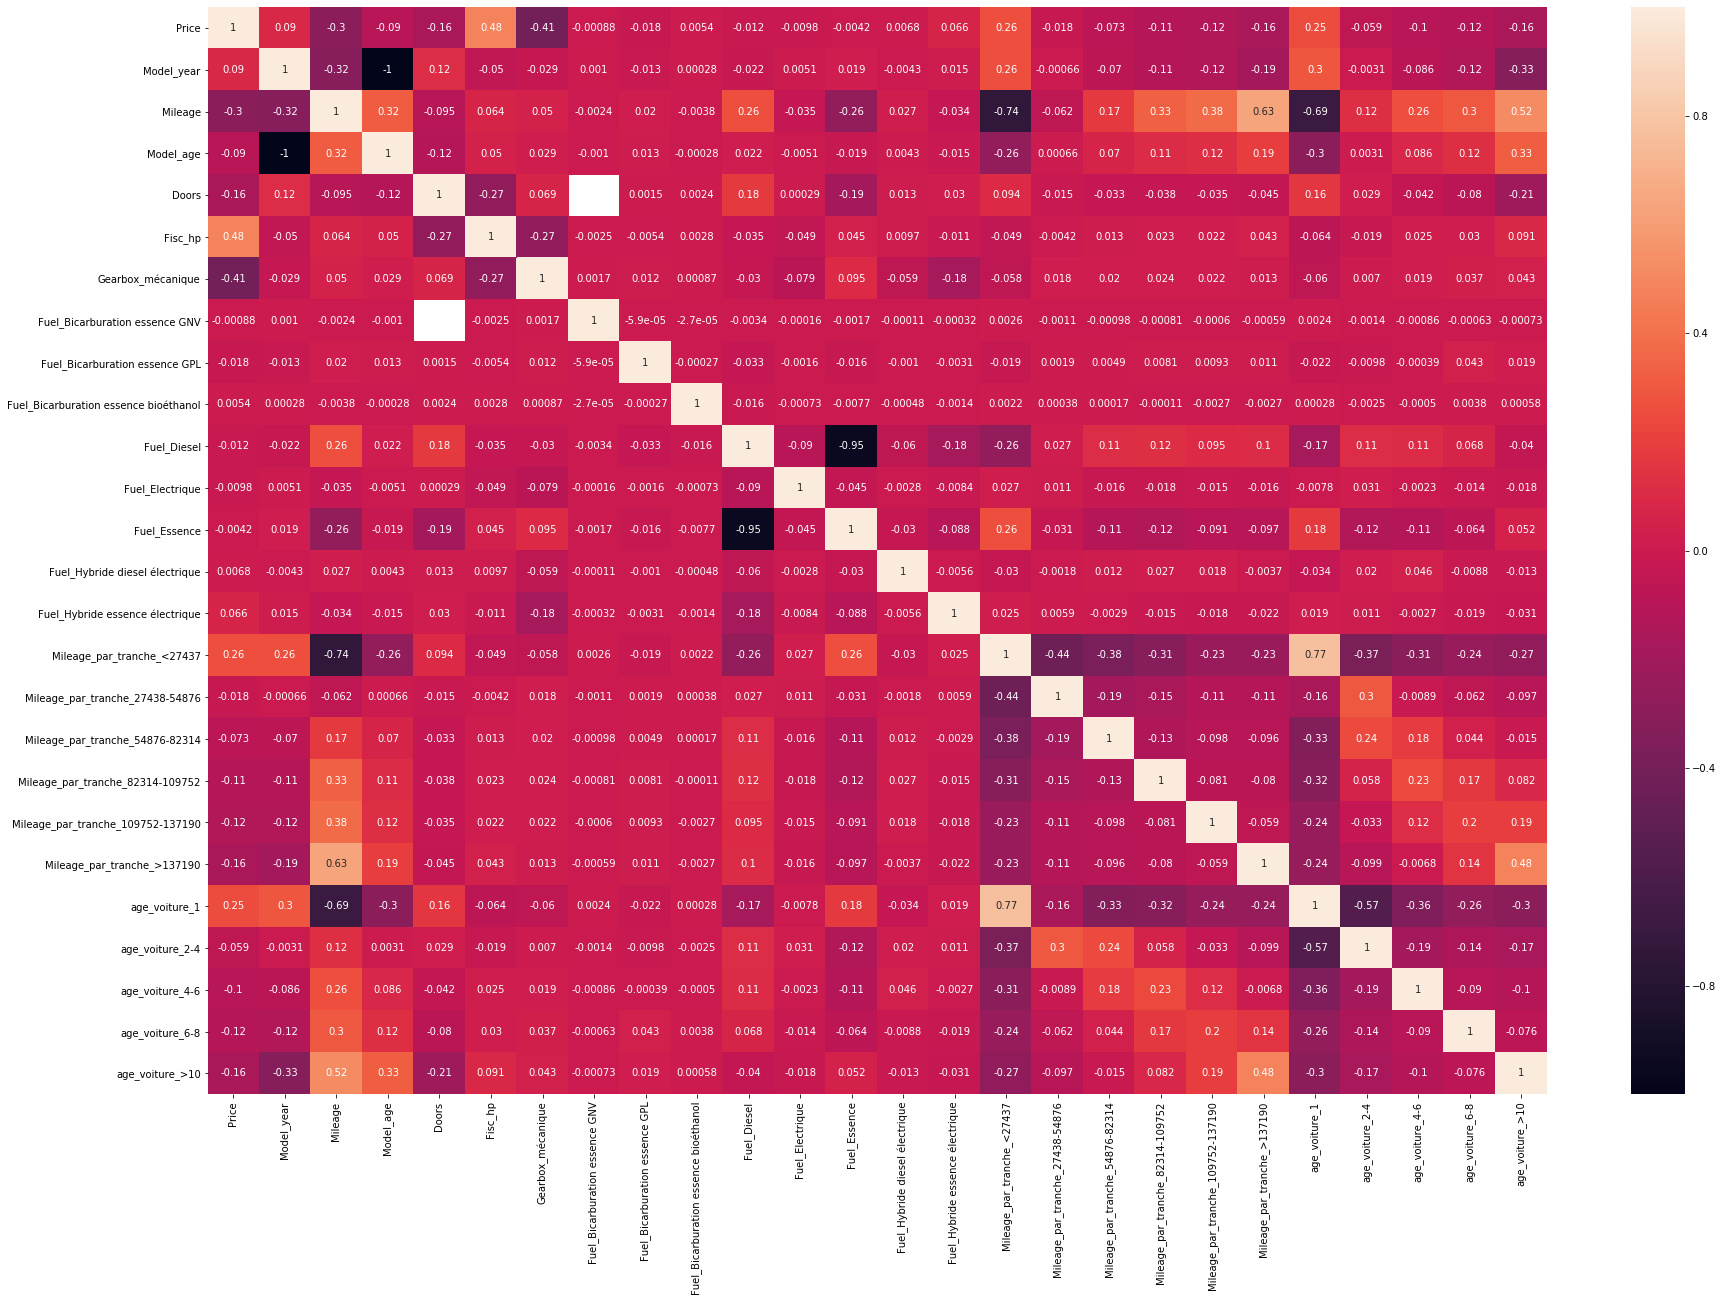

In [42]:
plt.figure(figsize=(30,20))
sns.heatmap(df.corr(), annot=True)

In [59]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((115264, 24), (49400, 24), (115264,), (49400,))

In [60]:
X_train.head(25)

,Make,Model,Doors,Fisc_hp,version,Gearbox_mécanique,Fuel_Bicarburation essence GPL,Fuel_Bicarburation essence bioéthanol,Fuel_Diesel,Fuel_Electrique,...,Mileage_par_tranche_27438-54876,Mileage_par_tranche_54876-82314,Mileage_par_tranche_82314-109752,Mileage_par_tranche_109752-137190,Mileage_par_tranche_>137190,age_voiture_1,age_voiture_2-4,age_voiture_4-6,age_voiture_6-8,age_voiture_>10
3584,5,39,5.0,5.0,2605,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
77771,6,98,5.0,10.0,482,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
92818,2,131,5.0,5.0,22660,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4417,10,35,5.0,6.0,3078,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
135163,2,40,4.0,12.0,27453,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
18029,29,130,5.0,6.0,8561,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1596,29,130,5.0,6.0,583,1,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
46570,22,161,5.0,6.0,2081,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4862,21,129,5.0,5.0,3317,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
85870,11,215,5.0,6.0,3758,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [61]:
y_train.head(5)

3584      24762.0
77771     56786.0
92818     23990.0
4417      18765.0
135163    25215.0
Name: Price, dtype: float64

## Train / Predict

In [62]:
lreg = LinearRegression()

In [63]:
lreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [64]:
y_pred = lreg.predict(X_test)

In [65]:
mean_absolute_percentage_error(y_test, y_pred)

27.673568296977997

In [66]:
r2_score(y_test, y_pred)

0.6876934864855506

In [67]:
y_pred

array([35409.88857248, 12704.62505012, 15691.96082773, ...,
       23437.44737278, 11984.29494893, 11570.75004491])

In [68]:
y_test.to_numpy()

array([50014., 14308., 14046., ..., 23396., 12602., 12873.])

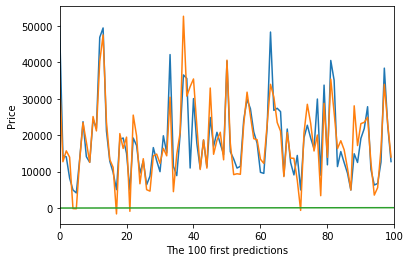

In [69]:
plt.plot(y_test.to_numpy()[0:100])
plt.plot(y_pred[0:100])
plt.xlim([0, 100])
plt.xlabel('The 100 first predictions')
plt.ylabel('Price')
plt.plot([-100, 100], [-100, 100])